### HolidayCheck Case Study

#### 1. Extrahieren der Daten von der Guardian Media Group API

Um die Daten der von der Guardian Media Group API zu extrahieren, habe ich ein Package geschrieben, mit Hilfe dessen man einen Funktion aufrufen kann um alle Artikel über Justin Trudeau zu extrahieren.<br>
Der Code dazu ist im Ordner "trudeau" zu finden. Diese Entscheidung habe ich vor allem deshalb getroffen, weil es dadurch einfacher wird einen automatisierten Report zu erstellen.

In [15]:
# imports zur Datengewinnung
from trudeau import get_data

# Angabe des zu suchenden Begriffs, des Startdatums und des API-Keys
query = 'Trudeau'
start_date = '2018-01-01'
api_key = "91f67b2a-520b-4f9f-a4ca-edcb0d610454"

# Erstellen eins Pandas Datansatzes mit allen Artikeln
articles_df = get_data.get_articles(query, start_date, api_key)

#### 2. Zählen der täglich veröffentlichten Artikel

Im folgenden werden die "rohen" Daten nach Tagen gruppiert und die pro Tag veröffentlichten Artikel gezählt. Hierbei beschränke ich mich auf die Artikel in denen Justin Trudeau in der Überschrift genannt wird. Dies kann jederzeit einfach durch eine Anpassung der API-Adresse angepasst werden.

In [16]:
import pandas as pd

# Import von utility Funktionen
from trudeau import utils

# Erstellen eines Datensatzes mit aggregierten Daten
grouped_df = get_data.group_days(articles_df)

# Erstellen des Outputs in der gewünschten Form
output = pd.DataFrame()
output['Datum'] = grouped_df['date'].dt.date
output['Anzahl Artikel'] = grouped_df['numberOfArticles']

# Berechnung der Anzahl der insgesamt veröffentlichten Artikel
total = utils.df_metrics(grouped_df, 'numberOfArticles')[2]
print(f'Insgesamt wurden {total} Artikel über Justin Trudeau veröffentlicht.')
output



Insgesamt wurden 126 Artikel über Justin Trudeau veröffentlicht.


,Datum,Anzahl Artikel
0,2018-01-01,0
1,2018-01-02,0
2,2018-01-03,0
3,2018-01-04,0
4,2018-01-05,0
...,...,...
1521,2022-03-02,0
1522,2022-03-03,0
1523,2022-03-04,0
1524,2022-03-05,0


#### 3. Berechnen des Durchschnitts von Anzahl Artikel über den gesamten Zeitraum

In [17]:
# Berechnung des Durchschnitts
avg = utils.df_metrics(grouped_df, 'numberOfArticles')[0]
avg = round(avg, 4)
print(f'Durchschnittlich wurden seit dem 01.01.2018 täglich {avg} Artikel über ' +
        'Justin Trudeau veröffentlicht.')

Durchschnittlich wurden seit dem 01.01.2018 täglich 0.0826 Artikel über Justin Trudeau veröffentlicht.


#### 4. Hauptsection in der Artikel über Justin Trudeau veröffentlicht wurden

In [18]:
# Herausfinden der am häufigsten vertretenen Section
main_section = utils.get_mainsection(articles_df)
print(f'Der Name der Section in der die meisten Artikel veröffentlicht wurden' + 
        f'ist: {main_section}.')

Der Name der Section in der die meisten Artikel veröffentlicht wurdenist: World news.


#### 5. Zeitliche Entwicklung der Anzahl der Artikel

Um die zeitliche Entwicklung der Anzahl der Artikel zu zeigen, verwende ich einen Lineplot der Anzahl der täglich veröffentlichten Artikel

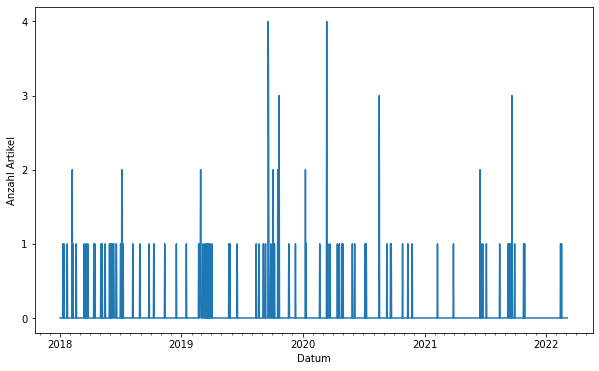

In [19]:
# plot imports
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator


years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')


fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.plot(grouped_df.date, grouped_df.numberOfArticles)

ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('Datum')
ax.set_ylabel('Anzahl Artikel')

plt.show()

#### 6. + 7. Ungewöhnliche Ereignisse in der Zeitreihe

Auf den ersten Blick, scheint es einige Zeiträume in der Zeitreihe zu geben, in denen besonders viele Artikel über Justin Trudeau veröffentlich wurden.<br>
Um genauer zu definieren, was als ungewöhnlich viele veröffentlichte Artikel gilt, wird ein gleitender Durchschnitt mit einem 7-Tage Fenster berechnet. Alle Zeiträume in denen dieser gleitende Durchschnitt mehr als 3 Standardabweichungen vom Mittelwert abweicht gelten final als ungewöhnlich.

In [20]:
# Fensterlänge des gleitenden Durchschnitts
window_size = 7
# Sicherheit mittels Anzahl Standardabweichungen
num_stds = 3

# Berechnung des gleitenden Durchschnitts, Mittelwerts und Standardabweichung
grouped_df['MA'] = grouped_df.rolling(window=window_size).mean()
ma_mean, ma_std = utils.df_metrics(grouped_df, 'MA')[:2]

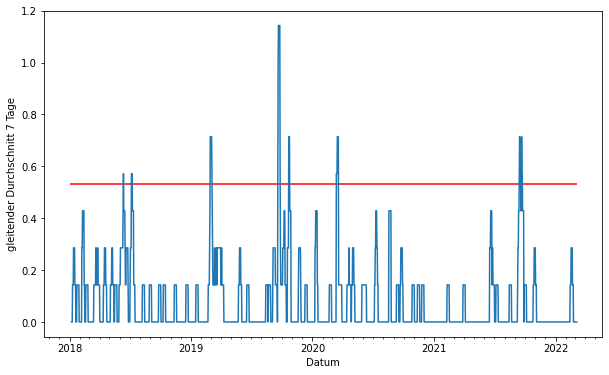

In [21]:
# Visualisierung des gleitenden Durchschnitts und 
# des Mittlewerts + 3 Standardabweichungen

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.plot(grouped_df.date, grouped_df.MA)
ax.hlines(y=ma_mean + num_stds * ma_std, xmin=min(grouped_df.date), 
            xmax=max(grouped_df.date), color='r')

ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.set_xlabel('Datum')
ax.set_ylabel('gleitender Durchschnitt 7 Tage')
plt.show()

#### 8. Grund der ungewöhnlichen Ereignisse

In [22]:
# Erkennung des ungewöhnlich hohen aufkommens von Artikeln
outlier_dfs = utils.outliers_by_std(grouped_df, 'MA', window_size, num_stds)
# Erstellen eines Datensatzes mit Artikeln + Metadaten 
# während der ungewöhnlichen Ereignisse
lda_dfs = [articles_df.loc[articles_df.webPublicationDate.dt.date.isin(df.date.dt.date)] 
                for df in outlier_dfs]

In [24]:
# Speichern der Datensätze mit Artikeln der ungewöhnlichen Ereignisse als CSV
for i, df in enumerate(lda_dfs):
    df.to_csv(f'spike{i}.csv', index=False)

Wenn man sich die Artikel der ungewöhnlichen Ereignisse anssieht, erkennt man folgende Gründe für das erhöhte Aufkommen von Artikeln über Justin Trudeau:
- 06.06.2018 - 12.06.2018: Streit mit den USA über Handelspolitik
- 02.07.2018 - 07.07.2018: Belästigungsanschuldigung an Trudeau von Reporterin
- 22.02.2019 - 03.01.2019: Regierungsskandal, SNC-Lavlin Bestechungsskandal 
- 19.09.2019 - 21.09.2019: Trudeau brownface/blackface Anschuldigungen
- 18.10.2019 - 22.10.2019: Wahlen in Kanada
- 13.03.2020 - 16.03.2020: Trudeau Coronavirusinfektion und kanadische Grenzschließungen
- 09.09.2021 - 21.09.2021: Wahlen in Kanada

Als versuch zur automatischen Erkennung der Gründe für außergewöhnliche Ereignisse habe ich zusätzlich einen Topic Modelling Algorithmus implementiert. Dies ist aber nur als Experiment anzusehen und bedürfte wahrscheinlich weiteren Anpassungen.

In [10]:
from trudeau import topic_modelling
lda_dfs = utils.preprocess(lda_dfs)
topics = topic_modelling.lda(lda_dfs)
topics

2022-03-06 22:40:35 INFO: Downloading default packages for language: en (English)...
2022-03-06 22:40:35 INFO: File exists: C:\Users\Felix\stanza_resources\en\default.zip.
2022-03-06 22:40:38 INFO: Finished downloading models and saved to C:\Users\Felix\stanza_resources.


[[(0,
   '0.032*"trump" + 0.018*"us" + 0.015*"trade" + 0.013*"leader" + 0.013*"president" + 0.012*"g7" + 0.011*"summit" + 0.011*"tariff" + 0.010*"donald" + 0.010*"tweet"')],
 [(0,
   '0.022*"reporter" + 0.017*"day" + 0.015*"editorial" + 0.013*"ford" + 0.013*"government" + 0.011*"apologise" + 0.010*"ontario" + 0.009*"grope" + 0.009*"interaction" + 0.009*"woman"')],
 [(0,
   '0.020*"party" + 0.015*"wilson_raybould" + 0.010*"leader" + 0.007*"first" + 0.007*"scandal" + 0.006*"country" + 0.006*"singh" + 0.006*"win" + 0.006*"prosecution" + 0.005*"wednesday"')],
 [(0,
   '0.008*"party" + 0.006*"image" + 0.006*"us" + 0.005*"week" + 0.005*"time" + 0.005*"leader" + 0.004*"call" + 0.004*"climate" + 0.004*"make" + 0.004*"people"')],
 [(0,
   '0.016*"party" + 0.012*"conservative" + 0.009*"leader" + 0.009*"election" + 0.008*"government" + 0.008*"liberals" + 0.008*"liberal" + 0.007*"country" + 0.007*"campaign" + 0.006*"seat"')],
 [(0,
   '0.010*"us" + 0.009*"coronavirus" + 0.008*"country" + 0.007*"vi

Der Topic Modelling Algorithmus gibt zu jedem ungewöhnlichen Ereignis die bezeichnendsten 10 Worte des jeweiligen Themas aus.

#### Automatisierung

Um einen täglichen automatischen Report anzufertigen habe ich ein Script report.py geschrieben, was sich ebenfalls in diesem Ordner befindet.<br>
Das Script aktualisiert den Datensatz mit allen Artikeln die am vorigen Tag erschienen sind (voriger Tag, da am heutigen Tag, je nach Ausführungszeipunkt immer noch Artikel erscheinen könnten) und verfasst eine Email, mit einer Grafik des zeitlichen Verlaufs und einigen Kenndaten, wie Durchschnitt und häufigste Section. Außerdem sind im Anhang der Mail, die aktuellen Daten.<br>
Dieses Script kann dann durch einen cronjob (Unix/Linux) oder den Windows Task Scheduler automatisiert werden.<br>
Das folgende Bild zeigt einein Screenshot wie eine solche Email aussehen würde:<br>
![title](mail_screenshot.png)